In [1]:
import torch
import torch.nn as nn
import time
import argparse

import os
import datetime

from torch.distributions.categorical import Categorical

# visualization 
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

device = torch.device("cpu"); gpu_id = -1 # select CPU

gpu_id = '0' # select a single GPU  
#gpu_id = '2,3' # select multiple GPUs  
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)  
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU name: {:s}, gpu_id: {:s}'.format(torch.cuda.get_device_name(0),gpu_id))   
    
print(device)
print('pytorch version = ',torch.__version__)

cpu
pytorch version =  1.10.0


In [2]:
from config import *
from utils.graph_utils import *
from utils.google_tsp_reader import GoogleTSPReader
from utils.plot_utils import *
from models.gcn_model import ResidualGatedGCNModel
from utils.model_utils import *

In [3]:
if torch.cuda.is_available():
    print("CUDA available, using GPU ID {}".format(config.gpu_id))
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
    torch.cuda.manual_seed(1)
else:
    print("CUDA not available")
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor
    torch.manual_seed(1)

CUDA not available


In [4]:
config_path = "configs/default.json"
config = get_config(config_path)
print("Loaded {}:\n{}".format(config_path, config))

Loaded configs/default.json:
{'expt_name': 'deafult', 'gpu_id': '0', 'train_filepath': './data/tsp25_concorde.txt', 'val_filepath': './data/tsp25_concorde.txt', 'test_filepath': './data/tsp25_concorde.txt', 'num_nodes': 100, 'num_neighbors': 6, 'node_dim': 4, 'voc_nodes_in': 2, 'voc_nodes_out': 2, 'voc_edges_in': 3, 'voc_edges_out': 2, 'beam_size': 10, 'hidden_dim': 50, 'num_layers': 3, 'mlp_layers': 2, 'aggregation': 'mean', 'max_epochs': 60, 'val_every': 5, 'test_every': 10, 'batch_size': 100, 'batches_per_epoch': 500, 'accumulation_steps': 1, 'learning_rate': 0.001, 'decay_rate': 1.01}


In [5]:
net = ResidualGatedGCNModel(config, dtypeFloat, dtypeLong)
if torch.cuda.is_available():
    net.cuda()
# Define optimizer
learning_rate = config.learning_rate
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [6]:
# Load checkpoint
log_dir = f"./logs/{config.expt_name}/"
if torch.cuda.is_available():
    checkpoint = torch.load(log_dir+"checkpoint_epoch1499.tar")
else:
    checkpoint = torch.load(log_dir+"checkpoint_epoch1499.tar", map_location='cpu')
# Load network state
net.load_state_dict(checkpoint['model_state_dict'],False)
# Load optimizer state
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# Load other training parameters
epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
val_loss = checkpoint['val_loss']
for param_group in optimizer.param_groups:
    learning_rate = param_group['lr']
print(f"Loaded checkpoint from epoch {epoch}")

Loaded checkpoint from epoch 1499


Class weights: [ 0.50818173 31.05590062]
torch.Size([1, 100, 100, 2])
tensor([4.4690e-01, 2.1776e-01, 1.3752e-01, 2.6411e-01, 1.3520e-02, 2.3265e-01,
        9.9025e-02, 8.7184e-03, 2.7049e-02, 1.6754e-02, 7.3585e-03, 8.3816e-03,
        3.4862e-12, 4.2819e-12, 8.1718e-13, 6.7472e-13, 2.4486e-03, 2.7182e-03,
        1.0643e-03, 9.7327e-04, 2.2623e-06, 4.2779e-06, 9.6356e-07, 5.4047e-07,
        2.1643e-24, 1.5517e-25, 5.8038e-26, 7.7056e-25, 7.9221e-20, 1.2293e-20,
        3.8183e-22, 2.1221e-21, 2.8885e-03, 9.6085e-04, 5.0919e-05, 1.0278e-04,
        1.3276e-22, 1.1703e-23, 2.9744e-24, 3.1493e-23, 6.9839e-13, 4.9107e-13,
        6.0407e-14, 8.3884e-14, 1.1936e-14, 6.5231e-15, 8.2642e-16, 1.4469e-15,
        4.5045e-13, 1.2450e-13, 3.2767e-14, 1.1152e-13, 8.3398e-05, 1.0083e-04,
        5.9549e-06, 5.1575e-06, 3.8070e-23, 3.2978e-24, 1.4640e-24, 1.6230e-23,
        2.4338e-23, 9.2107e-25, 5.1723e-25, 1.3119e-23, 1.7977e-03, 3.7263e-05,
        3.5238e-05, 1.6127e-03, 4.8956e-27, 1.9865

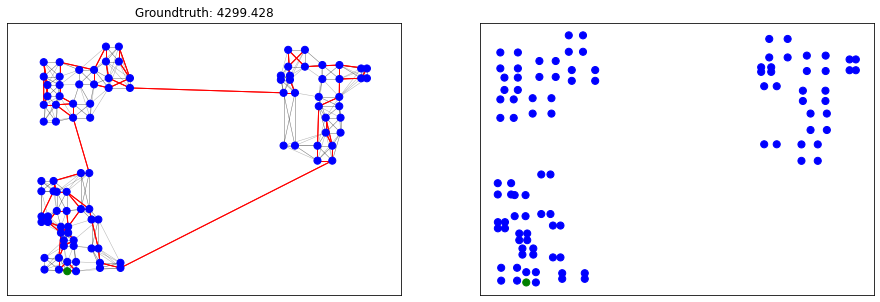

In [7]:
# Set evaluation mode
from torch.autograd import Variable
from sklearn.utils.class_weight import compute_class_weight
net.eval()

batch_size = 1
num_nodes = config.num_nodes
num_neighbors = config.num_neighbors
beam_size = config.beam_size
test_filepath = config.test_filepath
dataset = iter(GoogleTSPReader(num_nodes, num_neighbors, batch_size, test_filepath))
batch = next(dataset)

with torch.no_grad():
    # Convert batch to torch Variables
    x_edges = Variable(torch.LongTensor(batch.edges).type(dtypeLong), requires_grad=False)
    x_edges_values = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
    x_nodes = Variable(torch.LongTensor(batch.nodes).type(dtypeLong), requires_grad=False)
    x_nodes_coord = Variable(torch.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)
    y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeLong), requires_grad=False)
    y_nodes = Variable(torch.LongTensor(batch.nodes_target).type(dtypeLong), requires_grad=False)

    # Compute class weights
    edge_labels = y_edges.cpu().numpy().flatten()
    edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
    print("Class weights: {}".format(edge_cw))

    # Forward pass
    y_preds, loss = net.forward(x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges, edge_cw)
    loss = loss.mean()
    print(y_preds.shape)
    bs_nodes = 0
    # Plot prediction visualizations
    plot_predictions_beamsearch(x_nodes_coord, x_edges, x_edges_values, y_edges, y_preds, num_plots=batch_size)
    
    

In [ ]:
import math
import numpy as np
import torch.nn.functional as F
import random
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
class TransEncoderNet(nn.Module):
    """
    Encoder network based on self-attention transformer
    Inputs :  
      h of size      (bsz, nb_nodes, dim_emb)    batch of input cities
    Outputs :  
      h of size      (bsz, nb_nodes, dim_emb)    batch of encoded cities
      score of size  (bsz, nb_nodes, nb_nodes+1) batch of attention scores
    """
    
    def __init__(self, nb_layers, dim_emb, nb_heads, dim_ff, batchnorm):
        super(TransEncoderNet, self).__init__()
        assert dim_emb == nb_heads* (dim_emb//nb_heads) # check if dim_emb is divisible by nb_heads
        self.MHA_layers = nn.ModuleList( [nn.MultiheadAttention(dim_emb, nb_heads) for _ in range(nb_layers)] )
        self.linear1_layers = nn.ModuleList( [nn.Linear(dim_emb, dim_ff) for _ in range(nb_layers)] )
        self.linear2_layers = nn.ModuleList( [nn.Linear(dim_ff, dim_emb) for _ in range(nb_layers)] )   
        if batchnorm:
            self.norm1_layers = nn.ModuleList( [nn.BatchNorm1d(dim_emb) for _ in range(nb_layers)] )
            self.norm2_layers = nn.ModuleList( [nn.BatchNorm1d(dim_emb) for _ in range(nb_layers)] )
        else:
            self.norm1_layers = nn.ModuleList( [nn.LayerNorm(dim_emb) for _ in range(nb_layers)] )
            self.norm2_layers = nn.ModuleList( [nn.LayerNorm(dim_emb) for _ in range(nb_layers)] )
        self.nb_layers = nb_layers
        self.nb_heads = nb_heads
        self.batchnorm = batchnorm
        
    def forward(self, h):      
        # PyTorch nn.MultiheadAttention requires input size (seq_len, bsz, dim_emb) 
        h = h.transpose(0,1) # size(h)=(nb_nodes, bsz, dim_emb)  
        # L layers
        for i in range(self.nb_layers):
            h_rc = h # residual connection, size(h_rc)=(nb_nodes, bsz, dim_emb)
            h, score = self.MHA_layers[i](h, h, h) # size(h)=(nb_nodes, bsz, dim_emb), size(score)=(bsz, nb_nodes, nb_nodes)
            # add residual connection
            
            h = h_rc + h # size(h)=(nb_nodes, bsz, dim_emb)
            if self.batchnorm:
                # Pytorch nn.BatchNorm1d requires input size (bsz, dim, seq_len)
                h = h.permute(1,2,0).contiguous() # size(h)=(bsz, dim_emb, nb_nodes)
                h = self.norm1_layers[i](h)       # size(h)=(bsz, dim_emb, nb_nodes)
                h = h.permute(2,0,1).contiguous() # size(h)=(nb_nodes, bsz, dim_emb)
            else:
                h = self.norm1_layers[i](h)       # size(h)=(nb_nodes, bsz, dim_emb) 
            # feedforward
            h_rc = h # residual connection
            h = self.linear2_layers[i](torch.relu(self.linear1_layers[i](h)))
            h = h_rc + h # size(h)=(nb_nodes, bsz, dim_emb)
            if self.batchnorm:
                h = h.permute(1,2,0).contiguous() # size(h)=(bsz, dim_emb, nb_nodes)
                h = self.norm2_layers[i](h)       # size(h)=(bsz, dim_emb, nb_nodes)
                h = h.permute(2,0,1).contiguous() # size(h)=(nb_nodes, bsz, dim_emb)
            else:
                h = self.norm2_layers[i](h) # size(h)=(nb_nodes, bsz, dim_emb)
        # Transpose h
        h = h.transpose(0,1) # size(h)=(bsz, nb_nodes, dim_emb)
        return h, score
    

class Attention(nn.Module):
    def __init__(self, n_hidden):
        super(Attention, self).__init__()
        self.size = 0
        self.batch_size = 0
        self.dim = n_hidden
        
        v  = torch.FloatTensor(n_hidden)
        self.v  = nn.Parameter(v)
        self.v.data.uniform_(-1/math.sqrt(n_hidden), 1/math.sqrt(n_hidden))
        
        # parameters for pointer attention
        self.Wref = nn.Linear(n_hidden, n_hidden)
        self.Wq = nn.Linear(n_hidden, n_hidden)
    
    
    def forward(self, q, ref):       # query and reference
        self.batch_size = q.size(0)
        self.size = int(ref.size(0) / self.batch_size)
        q = self.Wq(q)     # (B, dim)
        ref = self.Wref(ref)
        ref = ref.view(self.batch_size, self.size, self.dim)  # (B, size, dim)
        
        q_ex = q.unsqueeze(1).repeat(1, self.size, 1) # (B, size, dim)
        # v_view: (B, dim, 1)
        v_view = self.v.unsqueeze(0).expand(self.batch_size, self.dim).unsqueeze(2)
        
        # (B, size, dim) * (B, dim, 1)
        u = torch.bmm(torch.tanh(q_ex + ref), v_view).squeeze(2)
        
        return u, ref
    
class LSTM(nn.Module):
    def __init__(self, n_hidden):
        super(LSTM, self).__init__()
        
        # parameters for input gate
        self.Wxi = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Whi = nn.Linear(n_hidden, n_hidden)    # W(ht)
        self.wci = nn.Linear(n_hidden, n_hidden)    # w(ct)
        
        # parameters for forget gate
        self.Wxf = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Whf = nn.Linear(n_hidden, n_hidden)    # W(ht)
        self.wcf = nn.Linear(n_hidden, n_hidden)    # w(ct)
        
        # parameters for cell gate
        self.Wxc = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Whc = nn.Linear(n_hidden, n_hidden)    # W(ht)
        
        # parameters for forget gate
        self.Wxo = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Who = nn.Linear(n_hidden, n_hidden)    # W(ht)
        self.wco = nn.Linear(n_hidden, n_hidden)    # w(ct)
    
    
    def forward(self, x, h, c):       # query and reference
        
        # input gate
        i = torch.sigmoid(self.Wxi(x) + self.Whi(h) + self.wci(c))
        # forget gate
        f = torch.sigmoid(self.Wxf(x) + self.Whf(h) + self.wcf(c))
        # cell gate
        c = f * c + i * torch.tanh(self.Wxc(x) + self.Whc(h))
        # output gate
        o = torch.sigmoid(self.Wxo(x) + self.Who(h) + self.wco(c))
        
        h = o * torch.tanh(c)
        
        return h, c

class HPN(nn.Module):
    def __init__(self, n_feature, n_hidden):

        super(HPN, self).__init__()
        self.city_size = 0
        self.batch_size = 0
        self.dim = n_hidden
        
        # lstm for first turn
        #self.lstm0 = nn.LSTM(n_hidden, n_hidden)main_training - Jupyter Notebook
        
        # pointer layer
        self.TransPointer = Attention(n_hidden)
        
        # lstm encoder
        self.encoder = LSTM(n_hidden)
        
        # trainable first hidden input
        h0 = torch.FloatTensor(n_hidden)
        c0 = torch.FloatTensor(n_hidden)
        # trainable latent variable coefficient
        print('here') 
        alpha = torch.ones(1)
        self.h0 = nn.Parameter(h0)
        self.c0 = nn.Parameter(c0)
        
        self.alpha = nn.Parameter(alpha)
        self.h0.data.uniform_(-1/math.sqrt(n_hidden), 1/math.sqrt(n_hidden))
        self.c0.data.uniform_(-1/math.sqrt(n_hidden), 1/math.sqrt(n_hidden))
        
        # embedding
        self.embedding_x = nn.Linear(n_feature, n_hidden)
        self.embedding_all = nn.Linear(n_feature, n_hidden)
        self.Transembedding_all = TransEncoderNet(6, 128, 8, 512, batchnorm=True)#6,128,8,512
        
        # vector to start decoding 
        self.start_placeholder = nn.Parameter(torch.randn(n_hidden))
    
    
    def forward(self,context,Transcontext, x, X_all, mask, h=None, c=None, latent=None):
        '''
        Inputs (B: batch size, size: city size, dim: hidden dimension)
        
        x: current city coordinate (B, 2)
        X_all: all cities' cooridnates (B, size, 2)
        mask: mask visited cities
        h: hidden variable (B, dim)
        c: cell gate (B, dim)
        latent: latent pointer vector from previous layer (B, size, dim)
        
        Outputs
        
        softmax: probability distribution of next city (B, size)
        h: hidden variable (B, dim)
        c: cell gate (B, dim)
        latent_u: latent pointer vector for next layer
        '''
        
        self.batch_size = X_all.size(0)
        self.city_size = X_all.size(1)
        # Check if this the first iteration loop
        if h is None or c is None:
            x          = self.start_placeholder  
            context = self.embedding_all(X_all)
            Transcontext,_ = self.Transembedding_all(context)
            
            # =============================
            # graph neural network encoder
            # =============================

            # (B, size, dim)
            Transcontext = Transcontext.reshape(-1, self.dim)

            h0 = self.h0.unsqueeze(0).expand(self.batch_size, self.dim)
            c0 = self.c0.unsqueeze(0).expand(self.batch_size, self.dim)

            h0 = h0.unsqueeze(0).contiguous()
            c0 = c0.unsqueeze(0).contiguous()
            
            # let h0, c0 be the hidden variable of first turn
            h = h0.squeeze(0)
            c = c0.squeeze(0)
        else:
            x          = self.embedding_x(x)
        # LSTM encoder1900/2500
        h, c = self.encoder(x, h, c)
        # query vector
        q = h
        # pointer
        u2 ,_ = self.TransPointer(q, Transcontext)
        # Avg Agg between the two attention vector
        u = u2
        latent_u = u.clone()
                
        u = 10 * torch.tanh(u)
        u = u + mask
        return context, Transcontext,F.softmax(u, dim=1), h, c, latent_u
# params= list(HPN(n_feature = 2, n_hidden = 128).parameters())
# print(len(params))
# for name,parameters in HPN(n_feature = 2, n_hidden = 128).named_parameters():
#     print(name,':',parameters.size())

In [ ]:
#test network 
Actor = HPN(n_feature = 2, n_hidden = 128)
print(Actor)
nb_param = 0
for param in Actor.parameters():
    nb_param += np.prod(list(param.data.size()))
print('Number of parameters:', nb_param)

# daniel rectangle feature handle

In [ ]:
'''
This part I designed the rectangle-characterized TSP, that means for every step the agent walk through a corner,
then he travel through the whole rectangle using zig-zag, finally he ends up at one of the rest corners of 
the rextangle, so, it equals the agent walk through three points at one step, in practice, I add three points into 
mask to make them unselectable.
'''
def rectangle_process(temp,idx,Y,Y0,mask,k,B,i,path_gazebo, visit_count, if_actor):
    Y1 = Y[zero_to_bsz, idx.data].clone()
    rectangle_inf = idx/4
    feature_table = temp.outcorner_getout(rectangle_inf,B)
    feature_table = torch.Tensor(feature_table).type(torch.long)
    if torch.cuda.is_available():
        feature_table = feature_table.cuda()
    Y_corner = Y[zero_to_bsz, feature_table[:,0].data].clone()
    if (i % 100 == 0)and(if_actor):
        path_gazebo.append([idx.data[0].tolist(),feature_table[:,0].data[0].tolist()])
    if k ==0:
        if torch.cuda.is_available():
            reward = torch.zeros(B).cuda()
        else:
            reward = torch.zeros(B)
    if k > 0:
        reward = torch.sum((Y1[:,(0,1)] - Y0[:,(0,1)])**2 , dim=1 )**0.5
        reward += torch.sum((Y_corner[:,(0,1)] - Y1[:,(0,1)])**2 , dim=1 )**0.5
        #dis = (Y1 - Y0)**2
        #dis_1 = (Y_corner - Y1)**2
        #reward = torch.maximum(dis[:,0],dis[:,1])**0.5
        #reward += torch.maximum(dis_1[:,0],dis_1[:,1])**0.5  
    visit_count[zero_to_bsz, idx.data] -= 1
    visit_count[zero_to_bsz, feature_table[:,0].data] -= 1
    visit_count[zero_to_bsz, feature_table[:,1].data] -= 1
    visit_count[zero_to_bsz, feature_table[:,2].data] -= 1
    if_revisited = visit_count[zero_to_bsz, idx.data]<=0
    if_revisited = -np.inf*if_revisited
    if_revisited[if_revisited!=if_revisited] = 0
    mask[zero_to_bsz, idx.data] += if_revisited
    mask[zero_to_bsz, feature_table[:,0].data] += if_revisited
    mask[zero_to_bsz, feature_table[:,1].data ] += if_revisited  
    mask[zero_to_bsz, feature_table[:,2].data ] += if_revisited
    
    
    
    return reward, Y_corner, Y_corner

In [ ]:
import yaml
from torch.distributions.categorical import Categorical
# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm_notebook
import torch.nn.functional as F
####### my own import file ##########
from listofpathpoint import input_handler
import cnc_input
import copy
#from hybrid_models import HPN
####### my own import file ##########
'''
so, the models we have are TransEncoderNet,
                            Attention
                            LSTM
                            HPN
each one have initial parameters and the forward part, 
once we have the forward part, the back propagation will 
finished automatically by pytorch  
'''
TOL = 1e-3
TINY = 1e-15
learning_rate = 1e-4   #learning rate
B = 128          #batch size
B_valLoop = 5
steps = 2500
n_epoch = 100       # epochs
map_number = 0
record_actor = []
record_critic = []
dimension = 4
speed_of_nozzle = 30
range_of_wait = 10
scale_of_the_map = (800,500,speed_of_nozzle*range_of_wait)

print('======================')
print('prepare to train')
print('======================')
print('Hyper parameters:')
print('learning rate', learning_rate)
print('batch size', B)
print('steps', steps)
print('epoch', n_epoch)
print('======================')

'''
instantiate a training network and a baseline network
'''


try:
    del Actor  # remove existing model
    del Critic # remove existing model
except:
    pass
Actor = HPN(n_feature = dimension, n_hidden = 128)
Critic = HPN(n_feature = dimension, n_hidden = 128)
optimizer = optim.Adam(Actor.parameters(), lr=learning_rate)

# Putting Critic model on the eval mode
Actor = Actor.to(device)
Critic = Critic.to(device)
Critic.eval()

epoch_ckpt = 0
tot_time_ckpt = 0

val_mean = []
val_std = []
maplist = ['10&15data/25_chips/25_3corners.json'
          ,'10&15data/25_chips/25_3corners.json','10&15data/25_chips/25_3corners.json'\
          ,'10&15data/25_chips/25_3corners.json','10&15data/25_chips/25_3corners.json'\
          ,'10&15data/25_chips/25_3corners.json'
          ]
          
plot_performance_train = []
plot_performance_baseline = []
# recording the result of the resent epoch makes it available for future
#*********************# Uncomment these lines to load the previous check point
"""
checkpoint_file = "checkpoint/mutimap_20.pkl"
checkpoint = torch.load(checkpoint_file, map_location=device)
epoch_ckpt = checkpoint['epoch'] + 1
tot_time_ckpt = checkpoint['tot_time']
plot_performance_train = checkpoint['plot_performance_train']
plot_performance_baseline = checkpoint['plot_performance_baseline']
Critic.load_state_dict(checkpoint['model_baseline'])
Actor.load_state_dict(checkpoint['model_train'])
optimizer.load_state_dict(checkpoint['optimizer'])

print('Re-start training with saved checkpoint file={:s}\n  Checkpoint at epoch= {:d} and time={:.3f}min\n'.format(checkpoint_file,epoch_ckpt-1,tot_time_ckpt/60))
"""

#***********************# Uncomment these lines to load the previous check point

# Main training loop
# The core training concept mainly upon Sampling from the actor
# then taking the greedy action from the critic

start_training_time = time.time()
time_stamp = datetime.datetime.now().strftime("%y-%m-%d--%H-%M-%S") # Load the time stamp

C = 0       # baseline => the object which the actor can compare
R = 0       # reward
C_critic = torch.Tensor([12000])
if torch.cuda.is_available():
    C_critic = C_critic.cuda()
temp = input_handler(maplist[map_number])
X_temp, mask_list_num = temp.final_ver_points()
print(mask_list_num)
#change the waiting time to the distance that we can measure
size = len(X_temp)
zero_to_bsz = torch.arange(B, device = device) # a list contains 0 to (batch size -1)

for corner in X_temp:
    corner[dimension -2] *= speed_of_nozzle
size_rec = mask_list_num[-1]
print(size_rec)

X_temp = torch.FloatTensor(X_temp)
visit_count_initial = X_temp[:,3]
visit_count_rec = []
for i in range(0,len(visit_count_initial),4):
    visit_count_rec.append(int(visit_count_initial[i]))
X = X_temp.repeat(B,1,1)
if torch.cuda.is_available():
    X = X.cuda()

for epoch in range(0, n_epoch):
    # re-start training with saved checkpoint
    epoch += epoch_ckpt # adding the number of the former epochs
    # Train the model for one epoch
    start = time.time() # record the starting time
    Actor.train() 
    path_gazebo = []
    for i_all in range(1, steps+1): # 1 ~ 2500 steps
        # mask some points that are not the first visited points
        if torch.cuda.is_available():
            R = torch.zeros(B).cuda()
            reward_recorder = torch.zeros(B,size_rec).cuda()
            idx_recorder = torch.zeros(B,size_rec).cuda()
            logprobs = 0
            reward = torch.zeros(B).cuda()
            mask = torch.zeros(B,size).cuda() # use mask to make some points impossible to choose
        else:
            R = torch.zeros(B)
            reward_recorder = torch.zeros(B,size_rec)
            idx_recorder = torch.zeros(B,size_rec)
            logprobs = 0
            reward = torch.zeros(B)
            mask = torch.zeros(B,size) # use mask to make some points impossible to choose
        x = torch.zeros(B,dimension)# Y[:,0,:] #set the first point to x
        h = None
        c = None
        context = None        # set Y_ini to the out corner
        Transcontext = None
        Y0 = None
        visit_count = visit_count_initial.repeat(B,1)
        if torch.cuda.is_available():
            visit_count = visit_count.cuda()
        # Actor Sampling phase
        for k in range(size_rec):
            Y = X.view(B,size,dimension)
            context, Transcontext, output, h, c, _ = Actor(context,Transcontext,x=x, X_all=X,h=h,
                                                           c=c, mask=mask)
            sampler = torch.distributions.Categorical(output)
            idx = sampler.sample()
            idx_recorder[:,k] = (idx/4).type(torch.long)
            #prepare for the back propagation of pytorch
            reward, Y0,x = rectangle_process(temp, idx,Y,Y0,mask,k,B,i_all,path_gazebo,
                                                visit_count, if_actor=True)
            R += reward
            reward_recorder[:,k] = R
            logprobs += torch.log(output[zero_to_bsz, idx.data] + TINY)
            
        #now is the time to check if any trajectory should be punished due to waiting on the same rectangle

        trajec_count = 0
        for path_time in zip(idx_recorder,reward_recorder):
            idx_time = zip(path_time[0],path_time[1])
            idx_time = sorted(idx_time, key=lambda x: x[0])
            total_idx = 0
            extra_waiting_time = 0
            for item in visit_count_rec:
                compare_list = []
                if item>1:
                    for i in range(int(item)):
                        compare_list.append(idx_time[int(total_idx + i)][1])
                    compare_list.sort(reverse=True)
                    total_idx += item
                    for i in range(len(compare_list)-1):
                        dis_step = compare_list[i] - compare_list[i+1]
                        dry_time = (range_of_wait/2)*speed_of_nozzle
                        if (dis_step) < (dry_time):
                            extra_waiting_time += dry_time - dis_step
                else:
                    total_idx += item
            R[trajec_count] += extra_waiting_time
            trajec_count+=1
                    
                
        
# # critic baseline phase, use the baseline to compute the actual reward of agent at that time
#         if torch.cuda.is_available():
#             C = torch.zeros(B).cuda()
#             reward_recorder = torch.zeros(B,size_rec).cuda()
#             idx_recorder = torch.zeros(B,size_rec).cuda()
#             baseline = torch.zeros(B).cuda()
#             mask = torch.zeros(B,size).cuda() # use mask to make some points impossible to choose

#         else:
#             C = torch.zeros(B)
#             reward_recorder = torch.zeros(B,size_rec)
#             idx_recorder = torch.zeros(B,size_rec)
#             baseline = torch.zeros(B)
#             mask = torch.zeros(B,size) # use mask to make some points impossible to choose
#         x = torch.zeros(B,dimension)#Y[:,0,:] #set the first point to x
#         h = None
#         c = None
#         context = None
#         Transcontext = None
#         C0 = None
#         visit_count = visit_count_initial.repeat(B,1)
#         if torch.cuda.is_available():
#             visit_count = visit_count.cuda()
#         # compute tours for baseline without grad "Cause we want to fix the weights for the critic"
#         with torch.no_grad():
#             for k in range(size_rec):     
#                 Y = X.view(B,size,dimension)
#                 #check if all the points to be masked,if so, raise the total reward R, and check again
#                 context, Transcontext, output, h, c, _ = Critic(context,Transcontext,x=x, X_all=X,h=h,
#                                                                 c=c, mask=mask)
#                 idx = torch.argmax(output, dim=1) # ----> greedy baseline critic
#                 idx_recorder[:,k] = (idx/4).type(torch.long)
#                 # prepare for the back propagation of pytorch
#                 baseline, C0,x = rectangle_process(temp,idx,Y,C0, mask,k,B,i_all,path_gazebo,
#                                                    visit_count,if_actor=False)
#                 C += baseline
#                 reward_recorder[:,k] = C
#             #now is the time to check if any trajectory should be punished due to waiting on the same rectangle

#             trajec_count = 0
#             for path_time in zip(idx_recorder,reward_recorder):
#                 idx_time = zip(path_time[0],path_time[1])
#                 idx_time = sorted(idx_time, key=lambda x: x[0])
#                 total_idx = 0
#                 extra_waiting_time = 0
#                 for item in visit_count_rec:
#                     compare_list = []
#                     if item>1:
#                         for i in range(int(item)):
#                             compare_list.append(idx_time[int(total_idx + i)][1])
#                         compare_list.sort(reverse=True)
#                         total_idx += item
#                         for i in range(len(compare_list)-1):
#                             dis_step = compare_list[i] - compare_list[i+1]
#                             dry_time = (range_of_wait/2)*speed_of_nozzle
#                             if (dis_step) < (dry_time):
#                                 extra_waiting_time += dry_time - dis_step
#                     else:
#                         total_idx += item
#                 C[trajec_count] += extra_waiting_time
#                 trajec_count+=1
        ###################
        # Loss and backprop handling 
        ###################
        loss = torch.mean((R - C_critic[0]) * logprobs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i_all % 100 == 0:
            print("epoch:{}, batch:{}/{}, reward:{}".format(epoch, i_all, steps,R.mean().item()))
            record_actor.append(R.mean().tolist())
            record_critic.append(C_critic[0].tolist())
            plt.plot(record_actor,'r:')
            plt.plot(record_critic,'b:')
            plt.show()
        if i_all % 100 == 0:
            print("record the last path to gazebo for showing up")
            #starting to show the path on simulated enviroment of cnc_machine 
            the_resent_path = temp.zig_zag_path(path_gazebo,mask_list_num)
            data = {'path':the_resent_path}
            data_1 = {'corners':path_gazebo}
            pathpoints_dir = os.path.join("pathpoints")
            if not os.path.exists(pathpoints_dir):
                os.makedirs(pathpoints_dir)
            name = 'pathpoints/path_points '+str(i)+'.yaml'
            with open(name, 'w') as file:
                documents = yaml.dump(data,file)
                documents = yaml.dump(data_1,file)
            path_gazebo = []
    time_one_epoch = time.time() - start #recording the work time of one epoch
    time_tot = time.time() - start_training_time + tot_time_ckpt
    ###################
    # Evaluate train model and baseline 
    # in this phase we just solve random instances with the actor and the critic
    # compare this soluation if we get any improvment we'll transfer the actor's
    # weights into the critic
    ###################
    # putting the actor in the eval mode
    Actor.eval()
    
    mean_tour_length_actor = 0
    mean_tour_length_critic = 0

    for step in range(0,B_valLoop):
        
        # compute tour for model and baseline
        # mask some points that are not the first visited points
        if torch.cuda.is_available():
            R = torch.zeros(B).cuda()
            reward_recorder = torch.zeros(B,size_rec).cuda()
            idx_recorder = torch.zeros(B,size_rec).cuda()
            reward = torch.zeros(B).cuda()
            mask = torch.zeros(B,size).cuda() # use mask to make some points impossible to choose
        else:
            R = torch.zeros(B)
            reward_recorder = torch.zeros(B,size_rec)
            idx_recorder = torch.zeros(B,size_rec)
            reward = torch.zeros(B)
            mask = torch.zeros(B,size) # use mask to make some points impossible to choose
        x = torch.zeros(B,dimension)# Y[:,0,:] #set the first point to x
        h = None
        c = None
        context = None        # set Y_ini to the out corner
        Transcontext = None
        Y0 = None
        visit_count = visit_count_initial.repeat(B,1)
        if torch.cuda.is_available():
            visit_count = visit_count.cuda()

        with torch.no_grad():
            for k in range(size_rec):
                Y = X.view(B,size,dimension)
                context, Transcontext, output, h, c, _ = Actor(context,Transcontext,x=x, X_all=X,h=h,
                                                               c=c, mask=mask)
                idx = torch.argmax(output, dim=1)
                idx_recorder[:,k] = (idx/4).type(torch.long)
                #prepare for the back propagation of pytorch
                reward, Y0,x = rectangle_process(temp, idx,Y,Y0,mask,k,B,i,path_gazebo,
                                                    visit_count, if_actor=False)
                R += reward
                reward_recorder[:,k] = R
            #now is the time to check if any trajectory should be punished due to waiting on the same rectangle

            trajec_count = 0
            for path_time in zip(idx_recorder,reward_recorder):
                idx_time = zip(path_time[0],path_time[1])
                idx_time = sorted(idx_time, key=lambda x: x[0])
                total_idx = 0
                extra_waiting_time = 0
                for item in visit_count_rec:
                    compare_list = []
                    if item>1:
                        for i in range(int(item)):
                            compare_list.append(idx_time[int(total_idx + i)][1])
                        compare_list.sort(reverse=True)
                        total_idx += item
                        for i in range(len(compare_list)-1):
                            dis_step = compare_list[i] - compare_list[i+1]
                            dry_time = (range_of_wait/2)*speed_of_nozzle
                            if (dis_step) < (dry_time):
                                extra_waiting_time += dry_time - dis_step
                    else:
                        total_idx += item
                R[trajec_count] += extra_waiting_time
                trajec_count+=1
            print('R_val = ',R[0])
        if torch.cuda.is_available():
            C = torch.zeros(B).cuda()
            reward_recorder = torch.zeros(B,size_rec).cuda()
            idx_recorder = torch.zeros(B,size_rec).cuda()
            baseline = torch.zeros(B).cuda()
            mask = torch.zeros(B,size).cuda() # use mask to make some points impossible to choose
        else:
            C = torch.zeros(B)
            reward_recorder = torch.zeros(B,size_rec)
            idx_recorder = torch.zeros(B,size_rec)
            baseline = torch.zeros(B)
            mask = torch.zeros(B,size) # use mask to make some points impossible to choose
        x = torch.zeros(B,dimension)#Y[:,0,:] #set the first point to x
        h = None
        c = None
        context = None
        Transcontext = None
        C0 = None
        visit_count = visit_count_initial.repeat(B,1)
        if torch.cuda.is_available():
            visit_count = visit_count.cuda()
        # compute tours for baseline without grad "Cause we want to fix the weights for the critic"
        with torch.no_grad():
            for k in range(size_rec):     
                Y = X.view(B,size,dimension)
                #check if all the points to be masked,if so, raise the total reward R, and check again
                context, Transcontext, output, h, c, _ = Critic(context,Transcontext,x=x, X_all=X,h=h,
                                                                c=c, mask=mask)
                idx = torch.argmax(output, dim=1) # ----> greedy baseline critic
                idx_recorder[:,k] = (idx/4).type(torch.long)
                # prepare for the back propagation of pytorch
                baseline, C0,x = rectangle_process(temp,idx,Y,C0, mask,k,B,i,path_gazebo,
                                                   visit_count,if_actor=False)
                C += baseline
                reward_recorder[:,k] = C
                    #now is the time to check if any trajectory should be punished due to waiting on the same rectangle

            trajec_count = 0
            for path_time in zip(idx_recorder,reward_recorder):
                idx_time = zip(path_time[0],path_time[1])
                idx_time = sorted(idx_time, key=lambda x: x[0])
                total_idx = 0
                extra_waiting_time = 0
                for item in visit_count_rec:
                    compare_list = []
                    if item>1:
                        for i in range(int(item)):
                            compare_list.append(idx_time[int(total_idx + i)][1])
                        compare_list.sort(reverse=True)
                        total_idx += item
                        for i in range(len(compare_list)-1):
                            dis_step = compare_list[i] - compare_list[i+1]
                            dry_time = (range_of_wait/2)*speed_of_nozzle
                            if (dis_step) < (dry_time):
                                extra_waiting_time += dry_time - dis_step
                    else:
                        total_idx += item
                C[trajec_count] += extra_waiting_time
                trajec_count+=1
            print('C_val = ',C[0])
        C_critic = [C[0]]
        mean_tour_length_actor  += R.mean().item()
        mean_tour_length_critic += C.mean().item()

    mean_tour_length_actor  =  mean_tour_length_actor  / B_valLoop
    mean_tour_length_critic =  mean_tour_length_critic / B_valLoop
    # evaluate train model and baseline and update if train model is better

    update_baseline = mean_tour_length_actor + TOL < mean_tour_length_critic

    print('Avg Actor {} --- Avg Critic {}'.format(mean_tour_length_actor,mean_tour_length_critic))

    if update_baseline:
        Critic.load_state_dict(Actor.state_dict())
        C_critic = [R[0]]
        print('My actor is going on the right road Hallelujah :) Updated')
    ###################
    # Valdiation train model and baseline on 1k random TSP instances
    ###################
    # erased by daniel due to the 1K tsp is not the scale I want to train  

    # For checkpoint
    plot_performance_train.append([(epoch+1), mean_tour_length_actor])
    plot_performance_baseline.append([(epoch+1), mean_tour_length_critic])
    # compute the optimally gap ==> this is interesting because there is no LKH or other optimal algorithms 
    # for the problem like this rectangle characterized map
    mystring_min = 'Epoch: {:d}, epoch time: {:.3f}min, tot time: {:.3f}day, L_actor: {:.3f}, L_critic: {:.3f}, update: {}'.format(
        epoch, time_one_epoch/60, time_tot/86400, mean_tour_length_actor, mean_tour_length_critic, update_baseline)

    print(mystring_min)
    print('Save Checkpoints')

    # Saving checkpoint
    checkpoint_dir = os.path.join("checkpoint")

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    torch.save({
        'epoch': epoch,
        'time': time_one_epoch,
        'tot_time': time_tot,
        'loss': loss.item(),
        'plot_performance_train': plot_performance_train,
        'plot_performance_baseline': plot_performance_baseline,
        'model_baseline': Critic.state_dict(),
        'model_train': Actor.state_dict(),
        'optimizer': optimizer.state_dict(),
        },'{}.pkl'.format(checkpoint_dir + "/checkpoint_" + time_stamp + "-n{}".format(size) + "-gpu{}".format(gpu_id)))


  




                
            
                
        
                        

In [ ]:
import torch
index = int(9.34)
table = [[1,2],[3,4]]
table_1 = [[3,44],[5,6]]
table = torch.as_tensor(table)
table_1 = torch.as_tensor(table_1)
result = torch.maximum(table_1[:,0],table_1[:,1])
print(result)

In [ ]:
import torch
t = torch.ones(10,3,2)
t[:,:,0] +=2
print(t)

